# Gaussian Mixture

In [1]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade kneed


In [3]:
pip install -U scikit-learn scipy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import mixture 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from kneed import KneeLocator
import seaborn as sns

df = pd.read_csv('../data/QueryGrosera_v4.csv', encoding= "latin_1")
df

,Reserva,Tipo_Habitacion,Clasificacion_tipo_habitacion,Paquete,Canal,Agencia,Estatus_res,Capacidad_hotel,Numero_personas,Numero_adultos,Numero_men,Numero_noches,Numero_habitaciones,IngresoMto,FechaRegistro,FechaLlegada,FechaSalida
0,6576,ESTD C/BALCON SN12ASB,ASB,WALK IN ...,FAX ...,SUNWING VACATIONS ...,SALIDA,735,1,1,0,1,1,101.60,2019-12-10,2020-01-15,2020-01-16
1,82869,MV LUXURY 1K SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20
2,82868,MV LUXURY 2Q SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,3,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20
3,62469,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,LADA 800 NACIONAL68 ...,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.12,2019-02-22,2019-02-22,2019-02-24
4,63254,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,MULTIVACACIONES 1,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.70,2019-02-12,2019-02-13,2019-02-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79981,63042,LUXURY 1K SN12GSU,GSU,WALK IN ...,LADA 800 NACIONAL68 ...,PRICETRAVEL HOLDING ...,RESERVACION EN TRANSICION,735,2,2,0,1,1,132946.80,2019-03-14,2019-03-14,2019-03-14
79982,40799,MASTER SUITE 1KSN12GMS,GMS,WALK IN ...,LADA 800 NACIONAL68 ...,CLIENTES PARTICULARES ...,RESERVACION O (R)REGISTRO,735,2,2,0,28,1,145544.00,2020-03-21,2021-01-13,2021-02-10
79983,60997,MASTER SUITE 1KSN12GMS,GMS,WALK IN ...,LADA 800 NACIONAL68 ...,CLIENTES PARTICULARES ...,SALIDA,735,2,2,0,52,1,166296.00,2019-02-12,2019-02-13,2019-04-06
79984,52804,MASTER SUITE 1KSN12GMS,GMS,WALK IN ...,LADA 800 NACIONAL68 ...,CLIENTES PARTICULARES ...,SALIDA,735,2,2,0,63,1,201474.00,2019-07-17,2020-01-11,2020-03-14


In [5]:
def remove_outliers(df, column_name, threshold=3):
    """
    Remove rows with outliers in a specific column of a DataFrame.
    
    Parameters:
        - df: pandas DataFrame
            The DataFrame containing the data.
        - column_name: str
            The name of the column to check for outliers.
        - threshold: int or float, optional (default=3)
            The number of standard deviations away from the mean to consider as an outlier.
    
    Returns:
        - pandas DataFrame
            The DataFrame with the outliers removed.
    """
    mean = np.mean(df[column_name])
    std = np.std(df[column_name])
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

def is_high_season(date):
    year = date.year
        #verano, asueto revolución, invierno, asueto constitución, asueto petróleo
    if (pd.Timestamp(year=year, month=7, day=17) <= date <= pd.Timestamp(year=year, month=8, day=27)) or \
       (pd.Timestamp(year=year, month=11, day=18) <= date <= pd.Timestamp(year=year, month=11, day=20)) or \
       (pd.Timestamp(year=year, month=12, day=18) <= date <= pd.Timestamp(year=year+1, month=1, day=5)) or \
       (pd.Timestamp(year=year, month=2, day=3) <= date <= pd.Timestamp(year=year, month=2, day=5)) or \
       (pd.Timestamp(year=year, month=3, day=16) <= date <= pd.Timestamp(year=year, month=3, day=18)) or \
        (pd.Timestamp(year=year, month=3, day=25) <= date <= pd.Timestamp(year=year, month=4, day=7)):
        return 'temporada alta'
    return 'temporada baja'

df_no_out = remove_outliers(df, "IngresoMto", threshold=3)

df_no_out['FechaLlegada'] = pd.to_datetime(df_no_out['FechaLlegada'])

df_no_out['Tipo_temporada'] = df_no_out['FechaLlegada'].apply(is_high_season)

df_no_out['Diferencia_reservacion_llegada'] = pd.to_datetime(df_no_out['FechaLlegada']) - pd.to_datetime(df['FechaRegistro'])

df_no_out

C:\Users\Taurino LG\AppData\Local\Temp\ipykernel_12324\2719864988.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_out['FechaLlegada'] = pd.to_datetime(df_no_out['FechaLlegada'])
C:\Users\Taurino LG\AppData\Local\Temp\ipykernel_12324\2719864988.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_out['Tipo_temporada'] = df_no_out['FechaLlegada'].apply(is_high_season)
C:\Users\Taurino LG\AppData\Local\Temp\ipykernel_12324\2719864988.py:42: SettingWithCopyWarning: 
A value is trying to be set 

,Reserva,Tipo_Habitacion,Clasificacion_tipo_habitacion,Paquete,Canal,Agencia,Estatus_res,Capacidad_hotel,Numero_personas,Numero_adultos,Numero_men,Numero_noches,Numero_habitaciones,IngresoMto,FechaRegistro,FechaLlegada,FechaSalida,Tipo_temporada,Diferencia_reservacion_llegada
0,6576,ESTD C/BALCON SN12ASB,ASB,WALK IN ...,FAX ...,SUNWING VACATIONS ...,SALIDA,735,1,1,0,1,1,101.60,2019-12-10,2020-01-15,2020-01-16,temporada baja,36 days
1,82869,MV LUXURY 1K SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20,temporada baja,89 days
2,82868,MV LUXURY 2Q SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,3,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20,temporada baja,89 days
3,62469,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,LADA 800 NACIONAL68 ...,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.12,2019-02-22,2019-02-22,2019-02-24,temporada baja,0 days
4,63254,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,MULTIVACACIONES 1,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.70,2019-02-12,2019-02-13,2019-02-15,temporada baja,1 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79212,84742,LUXURY 2Q SN12GSU,GSU,WALK IN ...,INTERNET ...,HOTELES S.A.,SALIDA,735,3,3,0,5,1,26520.15,2019-07-12,2019-07-17,2019-07-22,temporada alta,5 days
79213,55939,LUXURY 2Q SN12GSU,GSU,WALK IN ...,INTERNET ...,HOTELES S.A.,RESERVACION O (R)REGISTRO,735,2,2,0,4,1,26521.04,2020-03-12,2020-12-28,2021-01-01,temporada alta,291 days
79214,1379,LUXURY 2Q SN12GSU,GSU,WALK IN ...,LADA 800 NACIONAL68 ...,PRICETRAVEL HOLDING ...,SALIDA,735,2,2,0,6,1,26527.44,2019-03-19,2019-12-26,2020-01-01,temporada alta,282 days
79215,1378,LUXURY 1K SN12GSU,GSU,WALK IN ...,LADA 800 NACIONAL68 ...,PRICETRAVEL HOLDING ...,SALIDA,735,2,2,0,6,1,26527.56,2019-03-19,2019-12-26,2020-01-01,temporada alta,282 days


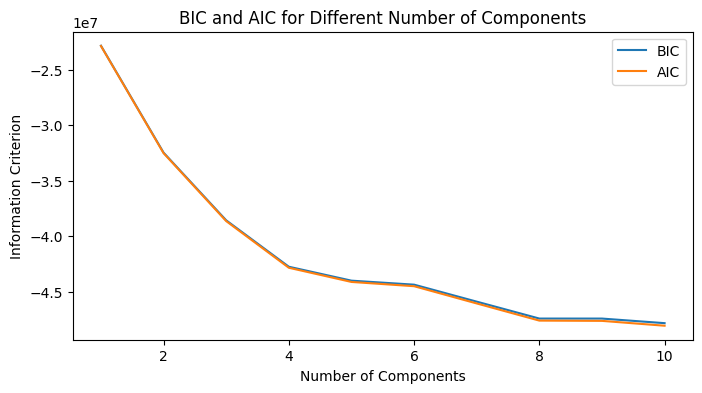

Optimal number of components according to BIC: 4
Optimal number of components according to AIC: 4


In [6]:
#Asumiendo que df_no_out ya está definido y limpio
columns_to_use = ['Tipo_Habitacion', 'Clasificacion_tipo_habitacion', 'Paquete', 'Canal', 'Estatus_res', 'Capacidad_hotel', 'Numero_personas', 'Numero_adultos', 'Numero_noches', 'IngresoMto', 'Tipo_temporada']
df_selected = df_no_out[columns_to_use]

#Preprocesamiento con OneHotEncoder para variables categóricas y StandardScaler para ingresos
categorical_features = ['Tipo_Habitacion', 'Clasificacion_tipo_habitacion', 'Paquete', 'Canal', 'Estatus_res', "Tipo_temporada"]
numeric_features = ['Capacidad_hotel', 'Numero_personas', 'Numero_adultos', 'Numero_noches', 'IngresoMto']


categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#Preprocesar los datos
data_transformed = preprocessor.fit_transform(df_selected)

#Suponiendo que 'data_transformed' podría ser disperso debido a one-hot encoding
if isinstance(data_transformed, np.ndarray):
    data_dense = data_transformed  
else:
    data_dense = data_transformed.toarray()  

#Realizar el análisis de codo
n_components = np.arange(1, 11)  
bics = []
aics = []
for n in n_components:
    gmm = mixture.GaussianMixture(n_components = n, random_state = 13)
    gmm.fit(data_dense)
    bics.append(gmm.bic(data_dense))
    aics.append(gmm.aic(data_dense))

#Plot BIC and AIC
plt.figure(figsize=(8, 4))
plt.plot(n_components, bics, label = 'BIC')
plt.plot(n_components, aics, label = 'AIC')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion')
plt.legend()
plt.title('BIC and AIC for Different Number of Components')
plt.show()

#Encuentra el número óptimo de componentes utilizando KneeLocator
knee_bic = KneeLocator(n_components, bics, curve = 'convex', direction = 'decreasing')
knee_aic = KneeLocator(n_components, aics, curve = 'convex', direction = 'decreasing')

print('Optimal number of components according to BIC:', knee_bic.elbow)
print('Optimal number of components according to AIC:', knee_aic.elbow)


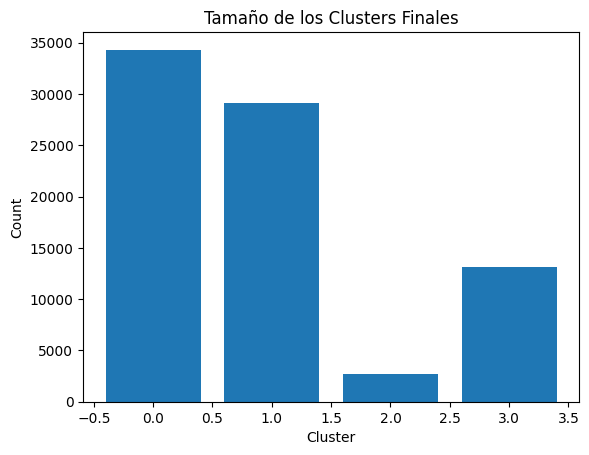

In [7]:
def to_dense(X):
    if isinstance(X, np.ndarray):
        return X
    else:
        return X.toarray()

#Define dense_transformer que utiliza la función to_dense
dense_transformer = FunctionTransformer(to_dense, accept_sparse=True)

#Preprocesamiento de características numéricas
numeric_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('to_dense', dense_transformer)  
])

#Preprocesamiento de características categóricas
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown = 'ignore')),
    ('to_dense', dense_transformer)  
])

#Combinar el preprocesamiento de datos numéricos y categóricos
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

#Definir y ajustar modelo final
pipeline_final = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', dense_transformer), 
    ('clusterer', mixture.GaussianMixture(n_components = knee_bic.elbow, random_state = 13))
])

pipeline_final.fit(df_selected)

#Predecir las etiquetas del cluster
labels_final = pipeline_final.predict(df_selected)

#Visualizar el tamaño de los clusters
plt.hist(labels_final, bins=range(knee_bic.elbow + 1), align = 'left', rwidth = 0.8)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Tamaño de los Clusters Finales')
plt.show()

C:\Users\Taurino LG\AppData\Local\Temp\ipykernel_12324\483094841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Cluster'] = labels_final
C:\Users\Taurino LG\AppData\Local\Temp\ipykernel_12324\483094841.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Cluster', y=col, data=df_selected, ax=axes[i], ci=None)
C:\Users\Taurino LG\AppData\Local\Temp\ipykernel_12324\483094841.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Cluster', y=col, data=df_selected, ax=axes[i], ci=None)
C:\Users\Taurino LG\AppData\Local\Temp\ipykernel_12324\483094841.py:10: FutureWarning: 

The `ci` parameter is deprecated. Us

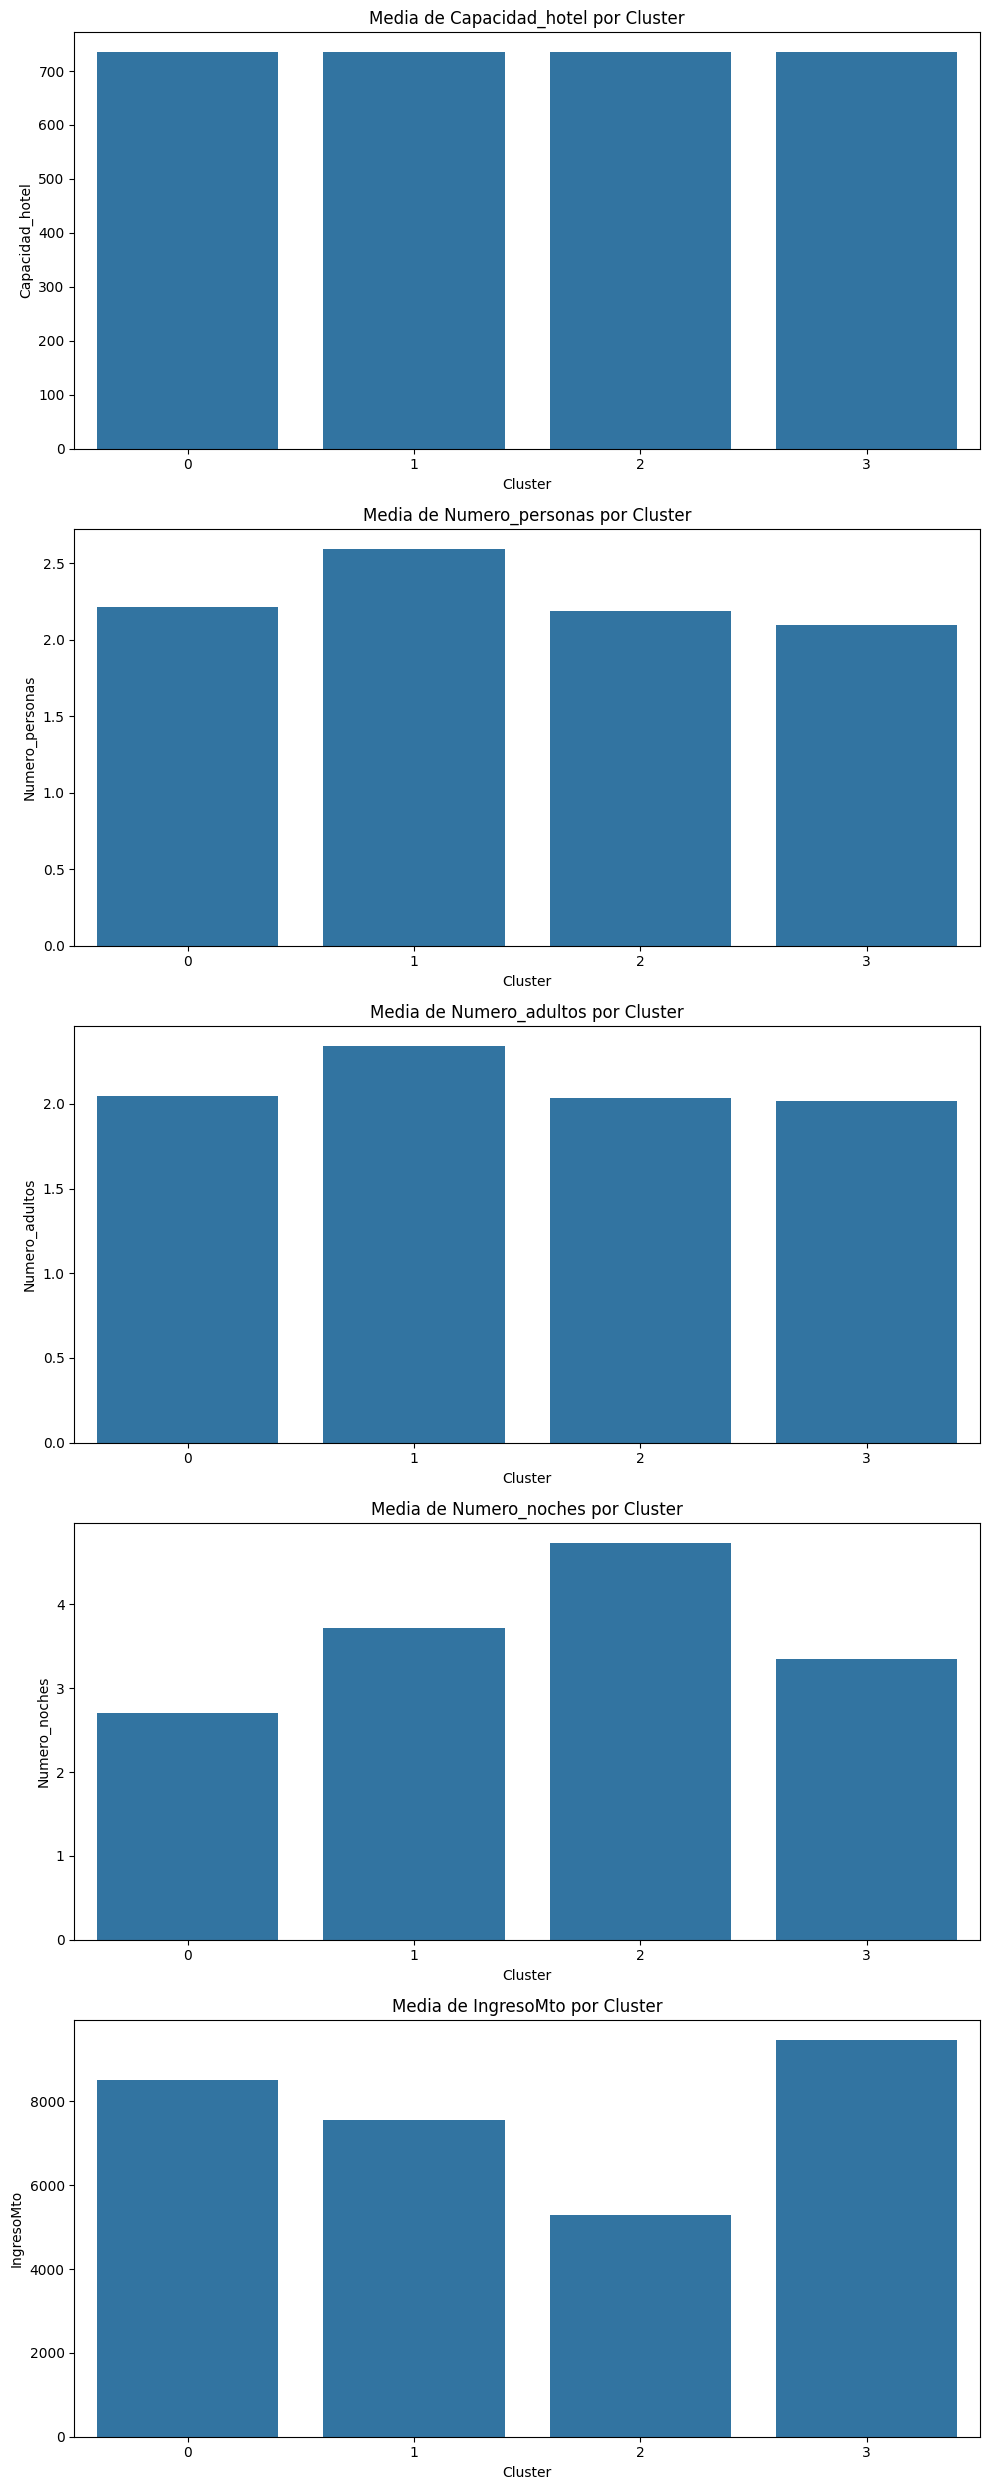

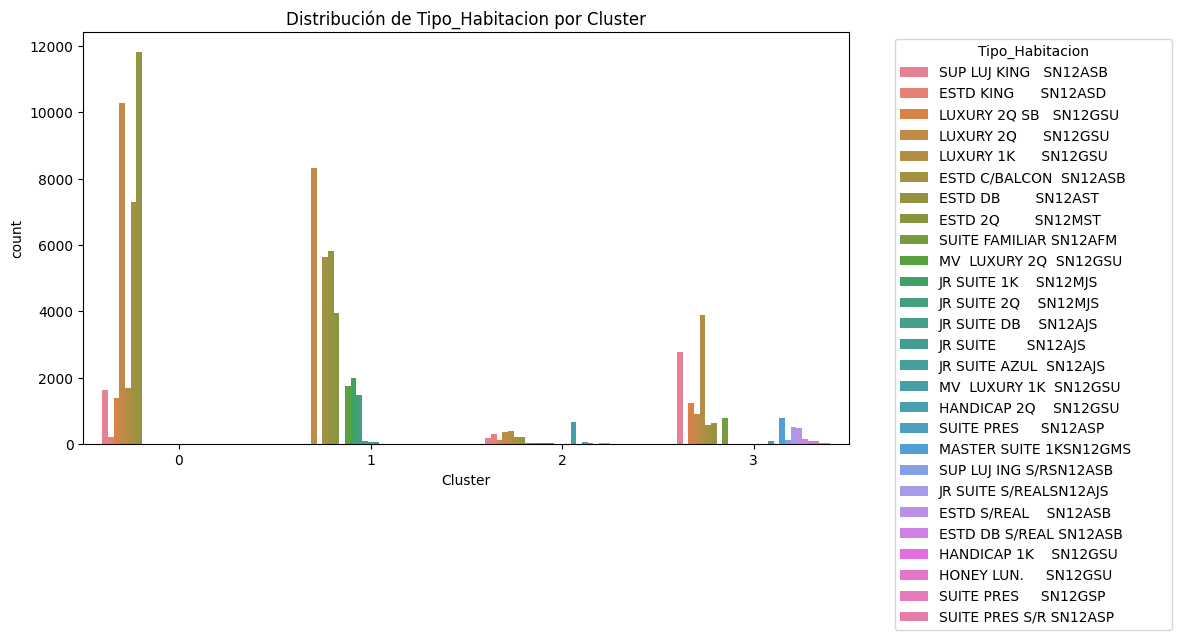

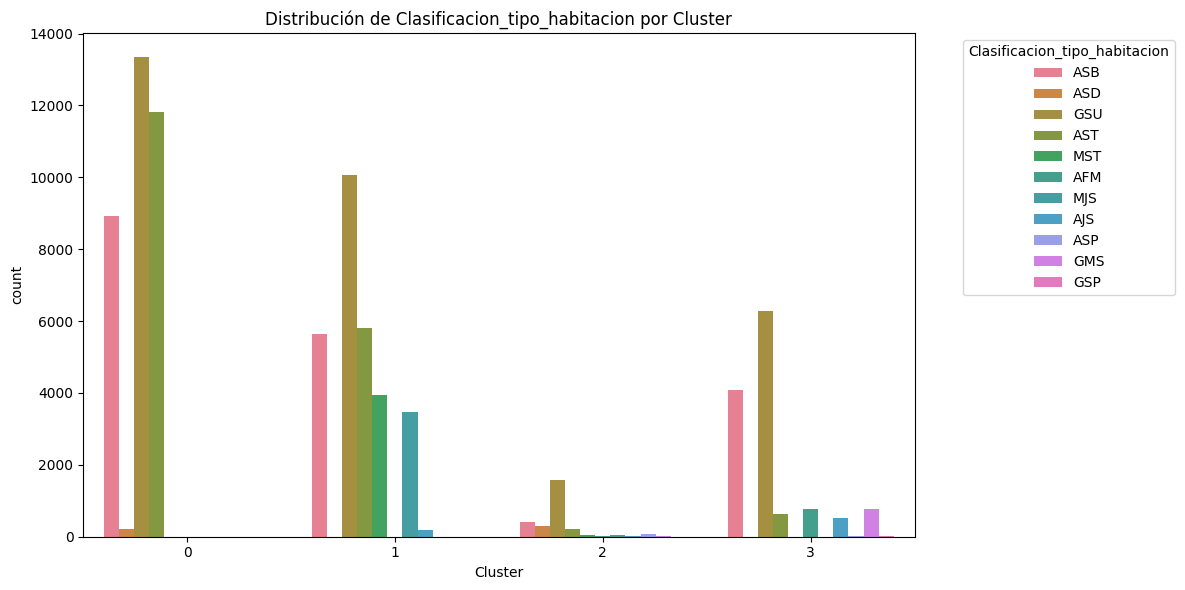

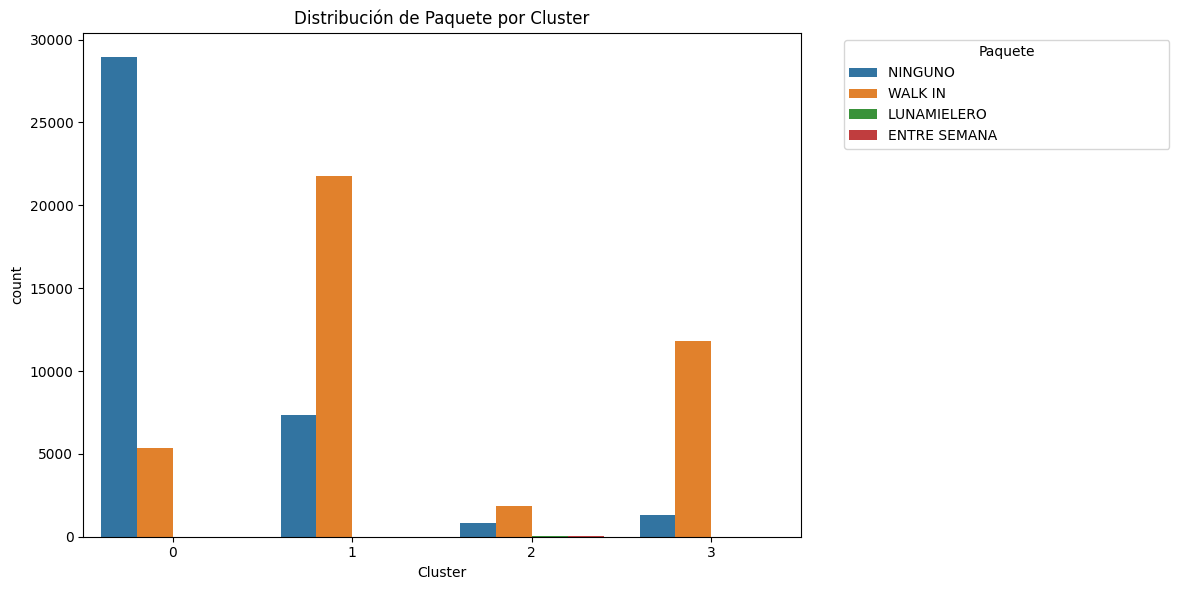

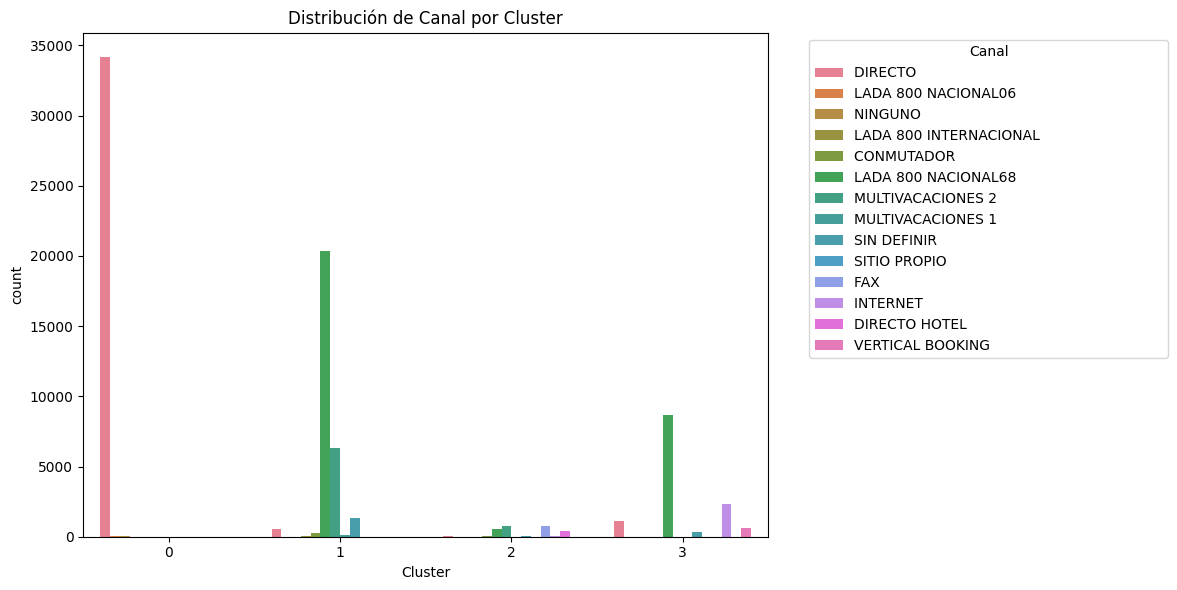

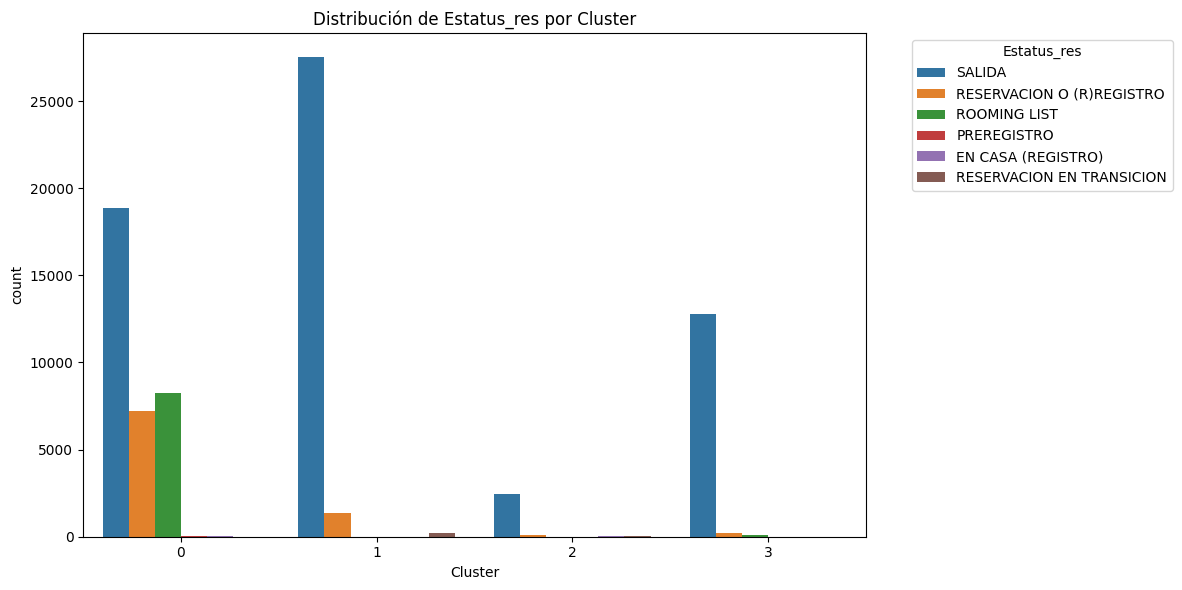

In [8]:
# Añadimos las etiquetas de los clusters al dataframe
df_selected['Cluster'] = labels_final

# Variables numéricas para análisis
numeric_features = ['Capacidad_hotel', 'Numero_personas', 'Numero_adultos', 'Numero_noches', 'IngresoMto']

# Gráficos para variables numéricas
fig, axes = plt.subplots(len(numeric_features), 1, figsize=(10, 5 * len(numeric_features)))
for i, col in enumerate(numeric_features):
    sns.barplot(x='Cluster', y=col, data=df_selected, ax=axes[i], ci=None)
    axes[i].set_title(f'Media de {col} por Cluster')
plt.tight_layout()
plt.show()

# Variables categóricas para análisis
categorical_features = ['Tipo_Habitacion', 'Clasificacion_tipo_habitacion', 'Paquete', 'Canal', 'Estatus_res']

# Gráficos para variables categóricas
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(x='Cluster', hue=feature, data=df_selected)
    plt.title(f'Distribución de {feature} por Cluster')
    plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


### Cluster 0
#### Viajes casuales
* Clientes mas frecuentes por hacerlo directo la reservación, denotado por ser el cluster más grande
* Menor numero de noches, indicando que son viajes más "casuales"
* Segundo con más ingreso por ser el que tiene más compras de Luxury 2Q y Estandar DB con posibles ingresos secundarios
* Al ser más "casuales" tienden a no comprar ningún paquete

### Cluster 1
#### Vacaciones 
* Mayor número de personas, sugiriendo viajes familiares de vacaciones
* Noches apenas superior a 3, apoyando las vacaciones de fin de semana
* 3ro con mayor revenue teniendo mayormente habitaciones Luxury 2Q y Estandar DB
* Al ser vacaciones planeadas tienden a ser por teléfono y planes multivacaciones

### Cluster 2
#### Lunamieleros
* Con paquetes lunamieleros y entre semana tienden a tener 2 personas y un mayor número de noches
* Habitaciones MV Luxury 1K, Luxury 1k, Luxury 2Q y estandar King predominan al ser viajes en pareja
* Reservaciones hechas principalmente por Multivacaciones y Fax al ser planeadas con antelación

### Cluster 3
#### Viaje negocios
* Es el cluster con el mayor ingreso medio por tener predominancia en las habitaciones Luxury 1k y Sup Luj King
* Tienden a ser agendados por teléfono e internet
* Se puede intuir que  se trata de viajes de negocios dada la naturaleza de las reservaciones, ya que son 2 personas por 3 noches en las habitaciones más lujosas principalmente en temporada baja

In [9]:
cluster0 = df_selected[ df_selected['Cluster'] == 0]
room_count = cluster0['Tipo_Habitacion'].value_counts()
room_count

Tipo_Habitacion
ESTD DB        SN12AST            11828
LUXURY 2Q      SN12GSU            10296
ESTD C/BALCON  SN12ASB             7292
LUXURY 1K      SN12GSU             1673
SUP LUJ KING   SN12ASB             1635
LUXURY 2Q SB   SN12GSU             1382
ESTD KING      SN12ASD              205
ESTD 2Q        SN12MST                1
SUITE FAMILIAR SN12AFM                1
Name: count, dtype: int64

In [10]:
cluster1 = df_selected[ df_selected['Cluster'] == 1]
room_count = cluster1['Tipo_Habitacion'].value_counts()
room_count

Tipo_Habitacion
LUXURY 2Q      SN12GSU            8326
ESTD DB        SN12AST            5808
ESTD C/BALCON  SN12ASB            5626
ESTD 2Q        SN12MST            3935
JR SUITE 1K    SN12MJS            1984
MV  LUXURY 2Q  SN12GSU            1732
JR SUITE 2Q    SN12MJS            1478
JR SUITE DB    SN12AJS              78
JR SUITE       SN12AJS              56
JR SUITE AZUL  SN12AJS              56
Name: count, dtype: int64

In [11]:
cluster2 = df_selected[ df_selected['Cluster'] == 2]
room_count = cluster2['Tipo_Habitacion'].value_counts()
room_count

Tipo_Habitacion
MV  LUXURY 1K  SN12GSU            667
LUXURY 1K      SN12GSU            374
LUXURY 2Q      SN12GSU            365
ESTD KING      SN12ASD            302
ESTD C/BALCON  SN12ASB            211
ESTD DB        SN12AST            205
SUP LUJ KING   SN12ASB            179
LUXURY 2Q SB   SN12GSU            126
SUITE PRES     SN12ASP             65
ESTD 2Q        SN12MST             38
JR SUITE 1K    SN12MJS             30
SUITE FAMILIAR SN12AFM             29
MV  LUXURY 2Q  SN12GSU             26
MASTER SUITE 1KSN12GMS             23
JR SUITE S/REALSN12AJS             17
ESTD S/REAL    SN12ASB             16
JR SUITE 2Q    SN12MJS             13
JR SUITE AZUL  SN12AJS              6
HONEY LUN.     SN12GSU              5
SUITE PRES     SN12GSP              5
SUP LUJ ING S/RSN12ASB              4
HANDICAP 1K    SN12GSU              4
ESTD DB S/REAL SN12ASB              4
HANDICAP 2Q    SN12GSU              4
JR SUITE       SN12AJS              2
JR SUITE DB    SN12AJS            

In [12]:
canal = cluster2['Canal'].value_counts()
canal

Canal
FAX                                                   757
MULTIVACACIONES 2                                     731
LADA 800 NACIONAL68                                   562
DIRECTO HOTEL                                         378
CONMUTADOR                                             81
DIRECTO                                                78
INTERNET                                               72
SIN DEFINIR                                            40
VERTICAL BOOKING                                       13
MULTIVACACIONES 1                                      10
Name: count, dtype: int64

In [13]:
cluster3 = df_selected[ df_selected['Cluster'] == 3]
room_count = cluster3['Tipo_Habitacion'].value_counts()
room_count

Tipo_Habitacion
LUXURY 1K      SN12GSU            3891
SUP LUJ KING   SN12ASB            2769
LUXURY 2Q SB   SN12GSU            1228
LUXURY 2Q      SN12GSU             901
SUITE FAMILIAR SN12AFM             773
MASTER SUITE 1KSN12GMS             769
ESTD DB        SN12AST             638
ESTD C/BALCON  SN12ASB             552
JR SUITE S/REALSN12AJS             512
ESTD S/REAL    SN12ASB             488
ESTD DB S/REAL SN12ASB             143
SUP LUJ ING S/RSN12ASB             128
HANDICAP 2Q    SN12GSU              96
HANDICAP 1K    SN12GSU              87
HONEY LUN.     SN12GSU              78
SUITE PRES S/R SN12ASP              26
SUITE PRES     SN12GSP              24
Name: count, dtype: int64

In [14]:
temporada = cluster3['Tipo_temporada'].value_counts()
temporada

Tipo_temporada
temporada baja    10276
temporada alta     2827
Name: count, dtype: int64

In [15]:
from sklearn.metrics import silhouette_score

# Asumimos que 'data_transformed' son tus datos preprocesados y 'labels_final' las etiquetas de clusters del modelo final
silhouette_avg = silhouette_score(data_transformed, labels_final)
print(f"El índice Silhouette promedio es: {silhouette_avg}")

El índice Silhouette promedio es: 0.0878212944795693


In [16]:
#log-Likelihood
log_likelihood = pipeline_final.score(df_selected)
print(f"Log-Likelihood: {log_likelihood}")

Log-Likelihood: 270.65467464290555


In [17]:
# Fit the full pipeline
pipeline_final.fit(df_selected)

# Create a new pipeline for transformation only (up to but not including the GMM)
transform_only_pipeline = Pipeline(steps=pipeline_final.steps[:-1])

# Transform the data using the same preprocessing as during training
data_transformed_for_bic = transform_only_pipeline.transform(df_selected)

# Now use the transformed data for BIC and AIC calculations
bic = pipeline_final.named_steps['clusterer'].bic(data_transformed_for_bic)
aic = pipeline_final.named_steps['clusterer'].aic(data_transformed_for_bic)
print(f"BIC: {bic}")
print(f"AIC: {aic}")

BIC: -42768791.33708003
AIC: -42861024.7223741


In [18]:
#df_selected.to_csv('Clusters_Gaussian.csv', index = False)